## Goals

To Understand and develop a model to predict number of days required for a vulnerabilities to get fixed using the number of contributers for the project and other data about the vulnerabilities.

## Question

If number of contributers to a project is know then is it possible to find how may days will it take for a vulnerabilities to get fixed?

In [1]:
import warnings
warnings.filterwarnings('ignore')

import datetime as dt
import numpy as np
import pandas as pa
import matplotlib.pyplot as plt
import seaborn as sns


# Test Train Split
from sklearn import model_selection

# Metrics
from sklearn.metrics import r2_score


# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [2]:
def rem(data):
    data = data.rename(columns={'cveid':'hashid','hash':'link','link':'lastModifiedDate'})
    data = data.drop(['link','hashid'],axis=1)
    data.index.names = ['cveid']
    data.lastModifiedDate = pa.to_datetime(data.lastModifiedDate).dt.date
    data.publishedDate =  pa.to_datetime(data.publishedDate).dt.date
    data['update_time'] = (data.lastModifiedDate-data.publishedDate).dt.days
    data.lastModifiedDate = pa.to_datetime(data.publishedDate).astype(int)
    data.publishedDate = pa.to_datetime(data.publishedDate).astype(int)
    return data
# data.head()

In [3]:
file = 'all/1-2018-all.csv'
file2017 = 'all/1-2017-all.csv'
file2016 = 'all/1-2016-all.csv'
file2015 = 'all/1-2015-all.csv'
file2014 = 'all/1-2014-all.csv'
file2013 = 'all/1-2013-all.csv'
file2012 = 'all/1-2012-all.csv'
file2011 = 'all/1-2011-all.csv'
file2010 = 'all/1-2010-all.csv'
dt2011 = rem(pa.read_csv(file2011))
dt2012 = rem(pa.read_csv(file2012))
dt2013 = rem(pa.read_csv(file2013))
dt2014 = rem(pa.read_csv(file2014))
dt2015 = rem(pa.read_csv(file2015))
dt2017 = rem(pa.read_csv(file2017))
dt2016 = rem(pa.read_csv(file2016))
dt2018 = rem(pa.read_csv(file))


## Combing data from different files

In [4]:
dt = pa.concat([dt2018,dt2017,dt2016,dt2015,dt2014,dt2013,dt2012,dt2011])

In [5]:
dt.shape

(4211, 13)

In [6]:
d = dt

## Dataset example

In [7]:
dt[['contr_count','update_time']].head(10)

,contr_count,update_time
cveid,,
CVE-2018-0046,83.0,50
CVE-2018-0429,8.0,62
CVE-2018-0500,368.0,261
CVE-2018-1000041,97.0,21
CVE-2018-1000041,1.0,21
CVE-2018-1000050,135.0,27
CVE-2018-1000052,167.0,27
CVE-2018-1000053,142.0,27
CVE-2018-1000070,107.0,29


## Handling Nan's

In [8]:
dt = dt.fillna(dt.median())

## Ploting Model Between [ Time to fix ( In Days ) to no. of contrebuters ]

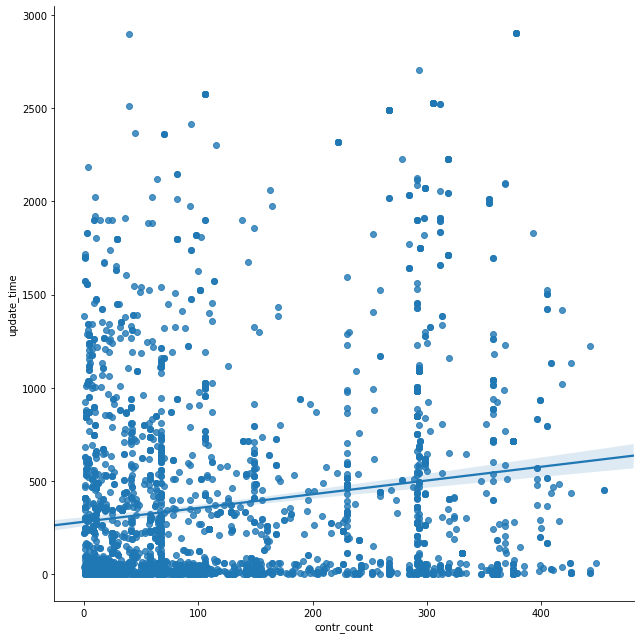

In [9]:
sns.lmplot(x='contr_count',y='update_time',data=d,fit_reg=True,size=9) 

In [10]:
dataset = d[['contr_count','update_time']].fillna(d[['contr_count','update_time']].median())

In [11]:
# dataset.head()

## Spliting data into Train and Test datasets

In [12]:
x_array,y_array = np.array(dt['contr_count']),np.array(dt['update_time'])
x_train,x_validt,y_train,y_validt = model_selection.train_test_split(x_array,y_array,test_size=0.3)
x_train = x_train.reshape(-1,1)
x_validt = x_validt.reshape(-1,1)
y_train = y_train.reshape(-1,1)
y_validt = y_validt.reshape(-1,1)

## Selecting Modes

In [13]:
models = list()

models.append(('LIR', LinearRegression()))
models.append(('RFG', RandomForestRegressor()))
results = []
names = []
scores = []

for name,model in models:
    kfold = model_selection.KFold(n_splits=10,random_state=7)
    cv_results = model_selection.cross_val_score(model,x_train,y_train,cv=kfold,scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name,cv_results.mean(),cv_results.std())
    scores.append(msg)

## R-Square Values of The Models

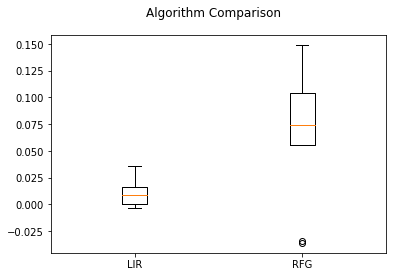

In [14]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Building A Random Forest Regression Model

In [15]:
md = RandomForestRegressor()

In [16]:
md.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

## RMS Value of the Model - Train Dataset

In [17]:
def rms(model, X, y):
    y_pred = model.predict(X)
    return round(np.sqrt(np.mean((y - y_pred) ** 2)),2)

In [18]:
prd = md.predict(x_validt)

In [19]:
rms(md,x_train,y_train)

604.58

## R- Square Value of the Model

In [20]:
round(r2_score(y_validt,prd),2) * 100

16.0

## RMS Value of the Model - Test Dataset

In [21]:
rms(md,x_validt,y_validt)

617.46

## Adding More Independent Varibles to the dataset

In [22]:
dt.head()

,lastModifiedDate,publishedDate,attk_com,imp_scr,severity,base_scr,expl_bility_score,sub_count,star_count,forks_count,watchers_count,contr_count,update_time
cveid,,,,,,,,,,,,,
CVE-2018-0046,1539129600000000000,1539129600000000000,MEDIUM,2.9,MEDIUM,4.3,8.6,79,470,432,470,83.0,50
CVE-2018-0429,1533772800000000000,1533772800000000000,LOW,6.4,MEDIUM,4.6,3.9,81,669,89,669,8.0,62
CVE-2018-0500,1531267200000000000,1531267200000000000,LOW,6.4,HIGH,7.5,10.0,669,15568,3379,15568,368.0,261
CVE-2018-1000041,1518134400000000000,1518134400000000000,MEDIUM,2.9,MEDIUM,4.3,8.6,14,188,29,188,97.0,21
CVE-2018-1000041,1518134400000000000,1518134400000000000,MEDIUM,2.9,MEDIUM,4.3,8.6,3,7,3,7,1.0,21


## Ploting Contrubuters to fix duration basaed on attack complexity 

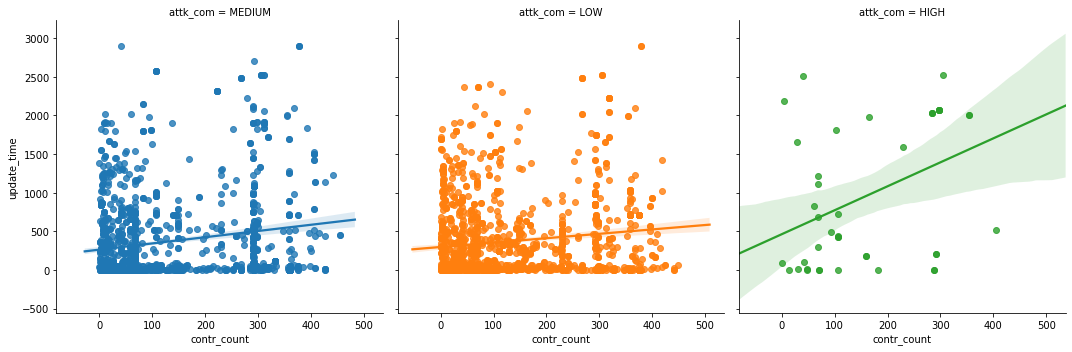

In [23]:
sns.lmplot(x='contr_count',y='update_time',hue='attk_com',col='attk_com',data=d,fit_reg=True)

## Ploting Contrubuters to fix duration basaed on Seveirity

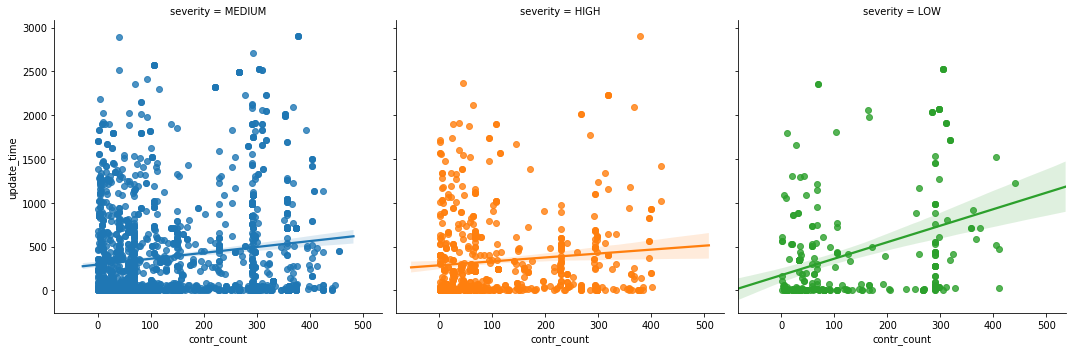

In [24]:
sns.lmplot(x='contr_count',y='update_time',hue='severity',col='severity',data=d[['contr_count','update_time','severity']],fit_reg=True)

## Handling Carogroical Values

In [25]:
att = pa.get_dummies(dt.attk_com,prefix='attk_com')
sev = pa.get_dummies(dt.severity,prefix='severity')
dt = pa.concat([dt.drop(['attk_com','severity'],axis=1),att,sev],axis=1)

In [26]:
dt.head()

,lastModifiedDate,publishedDate,imp_scr,base_scr,expl_bility_score,sub_count,star_count,forks_count,watchers_count,contr_count,update_time,attk_com_HIGH,attk_com_LOW,attk_com_MEDIUM,severity_HIGH,severity_LOW,severity_MEDIUM
cveid,,,,,,,,,,,,,,,,,
CVE-2018-0046,1539129600000000000,1539129600000000000,2.9,4.3,8.6,79,470,432,470,83.0,50,0,0,1,0,0,1
CVE-2018-0429,1533772800000000000,1533772800000000000,6.4,4.6,3.9,81,669,89,669,8.0,62,0,1,0,0,0,1
CVE-2018-0500,1531267200000000000,1531267200000000000,6.4,7.5,10.0,669,15568,3379,15568,368.0,261,0,1,0,1,0,0
CVE-2018-1000041,1518134400000000000,1518134400000000000,2.9,4.3,8.6,14,188,29,188,97.0,21,0,0,1,0,0,1
CVE-2018-1000041,1518134400000000000,1518134400000000000,2.9,4.3,8.6,3,7,3,7,1.0,21,0,0,1,0,0,1


# Building and Testing Different Models k-fold cross-validation

In [27]:
x_array,y_array = np.array(dt.drop(['update_time'],1)),np.array(dt['update_time'])
x_train,x_validt,y_train,y_validt = model_selection.train_test_split(x_array,y_array,test_size=0.3)

In [28]:
models = list()

models.append(('LIR', LinearRegression()))
models.append(('RFG', RandomForestRegressor()))
results = []
names = []
scores = []

for name,model in models:
    kfold = model_selection.KFold(n_splits=10,random_state=7)
    cv_results = model_selection.cross_val_score(model,x_train,y_train,cv=kfold,scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f' % (name,cv_results.mean())
    scores.append(msg)

## Models and Their  R Squares

In [29]:
for s in scores:
    print(s)

LIR: 0.280217
RFG: 0.456970


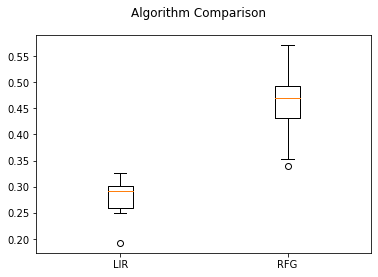

In [30]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Building Model

In [31]:
model = RandomForestRegressor()
model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

## RMS of the Model - Train Data

In [32]:
rms(model,x_train,y_train)

213.1

## Model Prediction

In [33]:
res= model.predict(x_validt)

## R - Square Value of the Model

In [34]:
r2_score(y_validt,res)

0.5719204430976093

## RMS of the Model - Test data

In [35]:
rms(model,x_validt,y_validt)

379.45

In [37]:
# plt.plot(x_train.squeeze(), y_train, 'o')
# plt.plot(x_validt.squeeze(), y_validt)

## Results and their Implications

R-Square shows how independent varibales are corelated to the dependent varible of a model <br>
Root Mean Square tells the difference between the acutal value and the predicted value
1. R- Square Values for Only Contributers models :&nbsp; 11.0 &nbsp;(Low Co-relation)

2. R- Square Values for Van. details + Conttribuers Model :&nbsp; 57.50&nbsp; ( Medium Co-relation )
